In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ta
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

C:\Users\rjc2\AppData\Local\Temp\ipykernel_14768\1492823180.py:7: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download("SPY", start="2010-01-01")
[*********************100%***********************]  1 of 1 completed
C:\Users\rjc2\AppData\Local\Temp\ipykernel_14768\1492823180.py:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  aord = yf.download("^AORD",  start="2010-01-01")   # All Ordinaries (Australia)
[*********************100%***********************]  1 of 1 completed
C:\Users\rjc2\AppData\Local\Temp\ipykernel_14768\1492823180.py:9: FutureWarning: YF.download() has changed argument auto_adjust default to True
  nikkei = yf.download("^N225",  start="2010-01-01")   # Nikkei 225 (Japan)
[*********************100%***********************]  1 of 1 completed
C:\Users\rjc2\AppData\Local\Temp\ipykernel_14768\1492823180.py:10: FutureWarning: YF.download() has changed argument auto_adjust default to True
  hsi = yf.d

Price,Close,High,Low,Open,Volume
Ticker,SPY,SPY,SPY,SPY,SPY
Date,,,,,
2010-01-04,85.279243,85.324391,83.909719,84.556858,118944600
2010-01-05,85.504951,85.542578,84.918014,85.226535,111579900
2010-01-06,85.565178,85.775873,85.354483,85.422204,116074400
2010-01-07,85.926323,86.031670,85.166311,85.407106,131091100
2010-01-08,86.212318,86.249945,85.527559,85.700628,126402800


In [ ]:
df = yf.download("SPY", start="2010-01-01")
aord = yf.download("^AORD",  start="2010-01-01")   # All Ordinaries (Australia)
nikkei = yf.download("^N225",  start="2010-01-01")   # Nikkei 225 (Japan)
hsi = yf.download("^HSI",   start="2010-01-01")   # Hang Seng Index (Hong Kong)
daxi = yf.download("^GDAXI", start="2010-01-01")   # DAX (Germany)
cac40 = yf.download("^FCHI",  start="2010-01-01")   # CAC 40 (France)
sp500 = yf.download("^GSPC",  start="2010-01-01")   # S&P 500 Index
dji = yf.download("^DJI",   start="2010-01-01")   # Dow Jones
nasdaq = yf.download("^IXIC",  start="2010-01-01")   # Nasdaq Composite


df.head()

In [2]:
df = df[['Open' , 'High' , 'Low' , 'Close' , 'Volume']].copy()

df.loc[:, 'Returns'] = df['Close'].pct_change()
aord.loc[:, 'Returns'] = aord['Close'].pct_change()
nikkei.loc[:, 'Returns'] = nikkei['Close'].pct_change()
hsi.loc[:, 'Returns'] = hsi['Close'].pct_change()
daxi.loc[:, 'Returns'] = daxi['Close'].pct_change()
cac40.loc[:, 'Returns'] = cac40['Close'].pct_change()
sp500.loc[:, 'Returns'] = sp500['Close'].pct_change()
dji.loc[:, 'Returns'] = dji['Close'].pct_change()
nasdaq.loc[:, 'Returns'] = nasdaq['Close'].pct_change()


df.head()


Price,Open,High,Low,Close,Volume,Returns
Ticker,SPY,SPY,SPY,SPY,SPY,
Date,,,,,,
2010-01-04,84.556858,85.324391,83.909719,85.279243,118944600,NaN
2010-01-05,85.226535,85.542578,84.918014,85.504951,111579900,0.002647
2010-01-06,85.422204,85.775873,85.354483,85.565178,116074400,0.000704
2010-01-07,85.407106,86.031670,85.166311,85.926323,131091100,0.004221
2010-01-08,85.700628,86.249945,85.527559,86.212318,126402800,0.003328


In [3]:
# RSI (14-day)
if isinstance(df.columns, pd.MultiIndex):
    df.columns = df.columns.get_level_values(0)
df.loc[:,'RSI'] = ta.momentum.RSIIndicator(df['Close'], window=14).rsi()

# MACD
macd = ta.trend.MACD(df['Close'])
df.loc[:, 'MACD'] = macd.macd()
df.loc[:, 'MACD_signal'] = macd.macd_signal()

# Moving averages
df.loc[:, 'MA10'] = df['Close'].rolling(window=10).mean()
df.loc[:, 'MA50'] = df['Close'].rolling(window=50).mean()


# Bollinger Bands (20-day)
bb_window = 20
df.loc[:, 'MA20'] = df['Close'].rolling(bb_window).mean()
df.loc[:, 'STD20'] = df['Close'].rolling(bb_window).std()

df.loc[:, 'Upper_BB'] = df['MA20'] + 2 * df['STD20']
df.loc[:, 'Lower_BB'] = df['MA20'] - 2 * df['STD20']


# Stochastic Oscillator (14, 3)

low14 = df['Low'].rolling(14).min()
high14 = df['High'].rolling(14).max()
df.loc[:, '%K'] = 100 * ((df['Close'] - low14) / (high14 - low14))
df.loc[:, '%D'] = df['%K'].rolling(3).mean()



In [4]:
# RSI long condition
rsi_condition = (df['MA10'] > df['MA50']) & (df['RSI'] < 65)

# MACD long condition
macd_condition = (df['MA10'] > df['MA50']) & (df['MACD'] > df['MACD_signal'])

# MA signal 
df.loc[:, 'Signal'] = np.where(df['MA10'] > df['MA50'], 1, 0)

# RSI strategy position (1 = long, 0 = flat)
df.loc[:, 'Position_RSI'] = np.where(rsi_condition, 1, 0)

# MACD strategy position (1 = long, 0 = flat)
df.loc[:, 'Position_MACD'] = np.where(macd_condition, 1, 0)

df.loc[:, 'Strategy_Returns'] = df['Returns'] * df['Signal'].shift(1)
df.loc[:, 'RSI_Returns'] = df['Returns'] * df['Position_RSI'].shift(1)
df.loc[:, 'MACD_Returns'] = df['Returns'] * df['Position_MACD'].shift(1)

# Bollinger Bands Strategy
# Long = when price < lower band
# Flat/Short = when price > upper band

df.loc[:, 'BB_Position'] = 0
df.loc[df['Close'] < df['Lower_BB'], 'BB_Position'] = 1
df.loc[df['Close'] > df['Upper_BB'], 'BB_Position'] = -1

df.loc[:, 'BB_Returns'] = df['Returns'] * df['BB_Position'].shift(1)

# Stochastic Oscillator Strategy
# Long when oversold (<20) AND %K rising
sto_long = (df['%K'] < 20) & (df['%K'] > df['%K'].shift(1))

# Short when overbought (>80) AND %K falling
sto_short = (df['%K'] > 80) & (df['%K'] < df['%K'].shift(1))

df.loc[:, 'STO_Position'] = 0
df.loc[sto_long, 'STO_Position'] = 1
df.loc[sto_short, 'STO_Position'] = -1

df.loc[:, 'STO_Returns'] = df['Returns'] * df['STO_Position'].shift(1)


df = df.dropna().copy()

In [5]:
# Cumulative returns
df.loc[:, 'Market_Cum'] = (1 + df['Returns']).cumprod()
df.loc[:, 'Strategy_Cum'] = (1 + df['Strategy_Returns']).cumprod()
df.loc[:, 'RSI_Cum'] = (1 + df['RSI_Returns']).cumprod()
df.loc[:, 'MACD_Cum'] = (1 + df['MACD_Returns']).cumprod()
df.loc[:, 'BB_Cum'] = (1 + df['BB_Returns']).cumprod()
df.loc[:, 'STO_Cum'] = (1 + df['STO_Returns']).cumprod()

df[['Market_Cum', 'Strategy_Cum', 'RSI_Cum', 'MACD_Cum', 'BB_Cum', 'STO_Cum']].tail()


Price,Market_Cum,Strategy_Cum,RSI_Cum,MACD_Cum,BB_Cum,STO_Cum
Date,,,,,,
2025-12-03,7.869436,3.181429,2.912370,1.957169,1.689756,1.272911
2025-12-04,7.875189,3.183755,2.914500,1.958600,1.689756,1.272911
2025-12-05,7.890148,3.189803,2.920036,1.962321,1.689756,1.272911
2025-12-08,7.866444,3.180219,2.911263,1.956425,1.689756,1.276735
2025-12-09,7.859655,3.177475,2.908750,1.954737,1.689756,1.277837


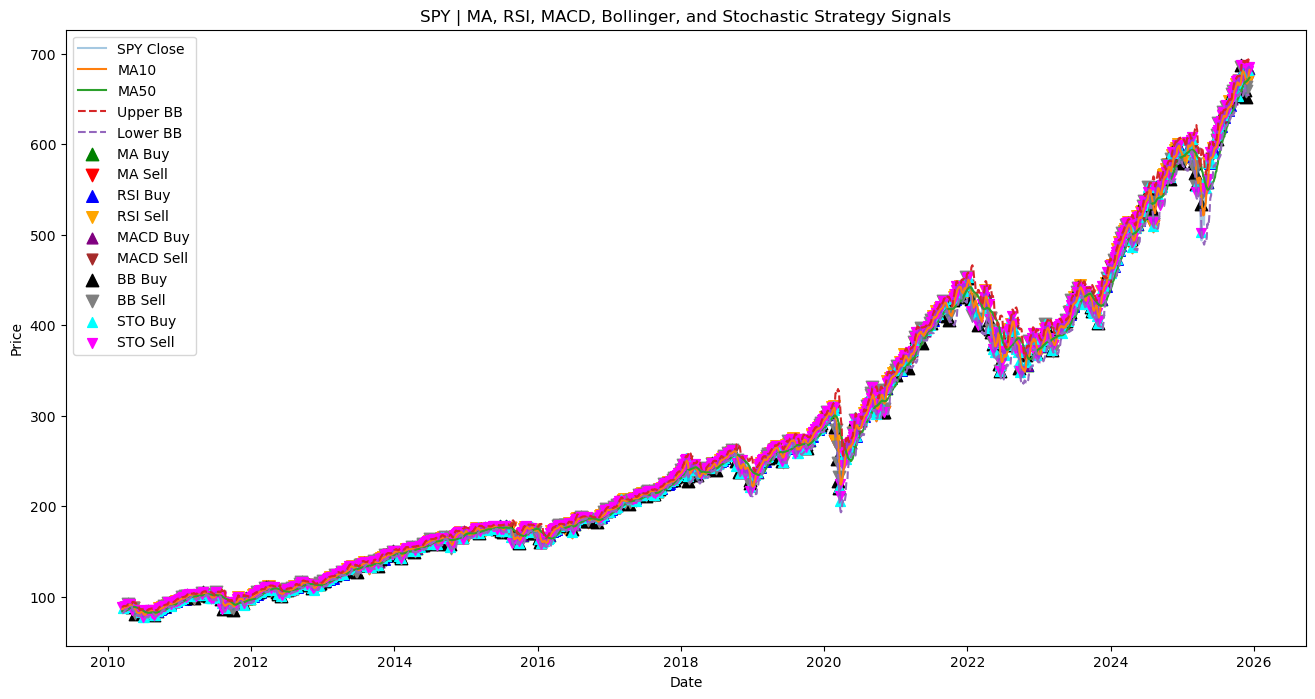

In [6]:
plt.figure(figsize=(16, 8))


# Price + Moving Averages

plt.plot(df.index, df['Close'], label='SPY Close', alpha=0.4)
plt.plot(df.index, df['MA10'], label='MA10')
plt.plot(df.index, df['MA50'], label='MA50')

# Bollinger Bands
plt.plot(df.index, df['Upper_BB'], label='Upper BB', linestyle='--')
plt.plot(df.index, df['Lower_BB'], label='Lower BB', linestyle='--')


# Base MA Trend Signals 

base_buy  = df[df['Signal'].diff() == 1]
base_sell = df[df['Signal'].diff() == -1]

plt.scatter(base_buy.index,  base_buy['Close'],  marker='^', s=80, color='green', label='MA Buy')
plt.scatter(base_sell.index, base_sell['Close'], marker='v', s=80, color='red',   label='MA Sell')

# RSI Strategy Signals

rsi_buy  = df[df['Position_RSI'].diff() == 1]
rsi_sell = df[df['Position_RSI'].diff() == -1]

plt.scatter(rsi_buy.index,  rsi_buy['Close'],  marker='^', s=70, color='blue',   label='RSI Buy')
plt.scatter(rsi_sell.index, rsi_sell['Close'], marker='v', s=70, color='orange', label='RSI Sell')

# MACD Strategy Signals

macd_buy  = df[df['Position_MACD'].diff() == 1]
macd_sell = df[df['Position_MACD'].diff() == -1]

plt.scatter(macd_buy.index,  macd_buy['Close'],  marker='^', s=60, color='purple', label='MACD Buy')
plt.scatter(macd_sell.index, macd_sell['Close'], marker='v', s=60, color='brown',  label='MACD Sell')

# Bollinger Bands Strategy Signals

bb_buy  = df[df['BB_Position'].diff() == 1]
bb_sell = df[df['BB_Position'].diff() == -1]

plt.scatter(bb_buy.index,  bb_buy['Close'],  marker='^', s=80, color='black', label='BB Buy')
plt.scatter(bb_sell.index, bb_sell['Close'], marker='v', s=80, color='gray',  label='BB Sell')

# Stochastic Strategy Signals

sto_buy  = df[df['STO_Position'].diff() == 1]
sto_sell = df[df['STO_Position'].diff() == -1]

plt.scatter(sto_buy.index,  sto_buy['Close'],  marker='^', s=50, color='cyan',    label='STO Buy')
plt.scatter(sto_sell.index, sto_sell['Close'], marker='v', s=50, color='magenta', label='STO Sell')


plt.title('SPY | MA, RSI, MACD, Bollinger, and Stochastic Strategy Signals')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

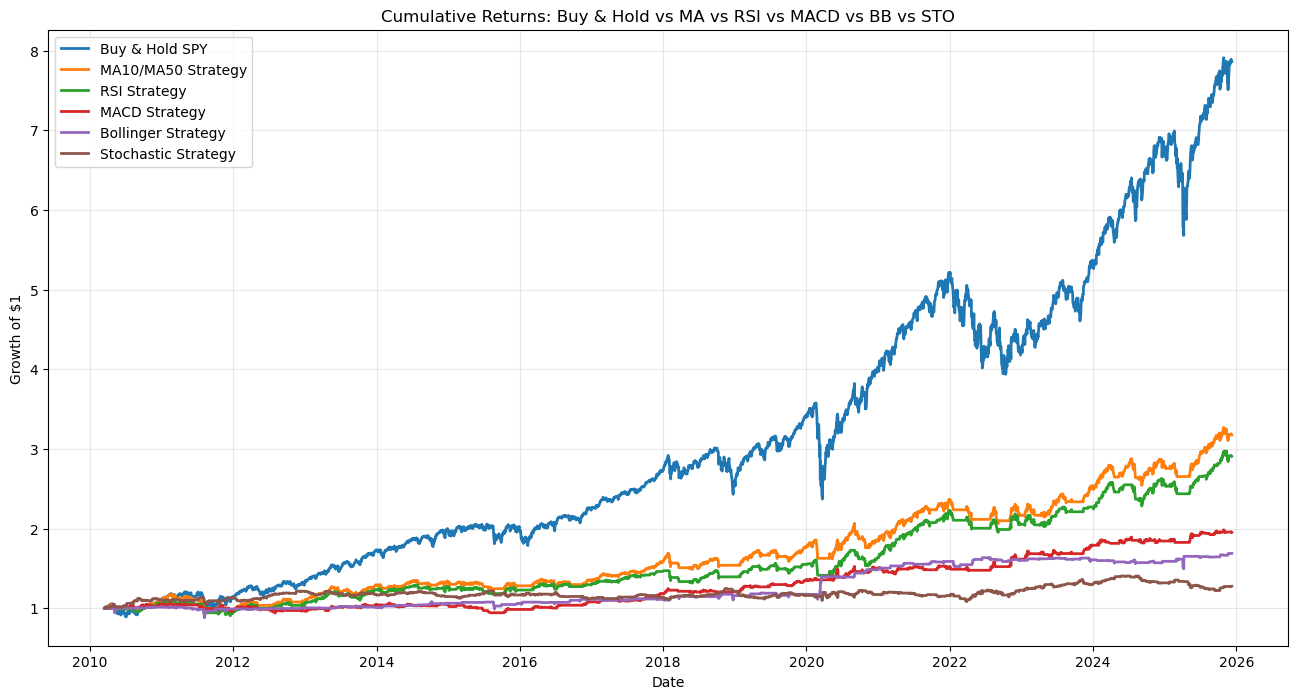

In [7]:
plt.figure(figsize=(16, 8))

# Plot cumulative returns for all rule-based strategies
plt.plot(df.index, df['Market_Cum'], label='Buy & Hold SPY',        linewidth=2)
plt.plot(df.index, df['Strategy_Cum'], label='MA10/MA50 Strategy',     linewidth=2)
plt.plot(df.index, df['RSI_Cum'], label='RSI Strategy',           linewidth=2)
plt.plot(df.index, df['MACD_Cum'], label='MACD Strategy',          linewidth=2)
plt.plot(df.index, df['BB_Cum'], label='Bollinger Strategy',     linewidth=2)
plt.plot(df.index, df['STO_Cum'], label='Stochastic Strategy',    linewidth=2)

plt.title('Cumulative Returns: Buy & Hold vs MA vs RSI vs MACD vs BB vs STO')
plt.xlabel('Date')
plt.ylabel('Growth of $1')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

In [8]:
# Build ML dataset: global markets + SPY indicators

ml = pd.DataFrame({
    'SPY': df['Returns'],
    'AORD': aord['Returns'],
    'NIKKEI': nikkei['Returns'],
    'HSI': hsi['Returns'],
    'DAX': daxi['Returns'],
    'CAC40': cac40['Returns'],
    'SP500': sp500['Returns'],
    'DJI': dji['Returns'],
    'NASDAQ': nasdaq['Returns'],
})

ml.loc[:, 'SPY_lag1'] = ml['SPY'].shift(1)
ml.loc[:, 'Target'] = ml['SPY'].shift(-1)
# Add technical indicators
ml.loc[:, 'RSI'] = df['RSI']
ml.loc[:, 'MACD'] = df['MACD']
ml.loc[:, 'MACD_sig'] = df['MACD_signal']
ml.loc[:, 'MA_gap'] = df['MA10'] - df['MA50']   # bullish/bearish trend indicator
ml.loc[:, 'MA20'] = df['MA20']
ml.loc[:, 'BB_width']  = df['Upper_BB'] - df['Lower_BB']      # volatility (band width)
ml.loc[:, 'BB_zscore'] = (df['Close'] - df['MA20']) / df['STD20']  # how far price is from middle band
ml.loc[:, 'STO_K'] = df['%K']
ml.loc[:, 'STO_D'] = df['%D']

# Clean dataset
ml = ml.dropna()

ml.head()

,SPY,AORD,NIKKEI,HSI,DAX,CAC40,SP500,DJI,NASDAQ,SPY_lag1,Target,RSI,MACD,MACD_sig,MA_gap,MA20,BB_width,BB_zscore,STO_K,STO_D
Date,,,,,,,,,,,,,,,,,,,,
2010-03-17,0.005928,0.012019,0.011684,0.017198,0.008925,0.004808,0.005822,0.004463,0.004659,0.007966,-0.000513,77.195394,1.195011,0.857666,2.547756,85.111398,6.724069,1.787420,94.843900,95.521813
2010-03-18,-0.000513,0.002219,-0.009491,-0.002517,-0.001987,-0.004980,-0.000326,0.004239,0.000917,0.005928,-0.005062,76.579668,1.247522,0.935637,2.827528,85.342035,7.027900,1.553165,93.026396,95.473064
2010-03-19,-0.005062,0.002542,0.007510,0.001882,-0.004970,-0.003235,-0.005086,-0.003450,-0.007055,-0.000513,0.005346,70.595468,1.238884,0.996286,2.951694,85.541726,7.116508,1.171018,77.040717,88.303671
2010-03-23,0.007033,0.008334,-0.004672,0.002605,0.004972,0.006250,0.007171,0.009544,0.008283,0.005346,-0.004855,75.786685,1.303405,1.099163,3.327404,86.068223,7.054600,1.499702,98.316367,87.713154
2010-03-24,-0.004855,0.003130,0.003794,0.000993,0.003611,-0.000693,-0.005493,-0.004838,-0.006823,0.007033,-0.001626,70.326368,1.291830,1.137697,3.465331,86.312825,6.844727,1.151062,86.253578,90.784108


In [9]:
X = ml.drop(columns=['Target'])
y = ml['Target']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, shuffle=False   
)
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [10]:
# Make predictions on train and test
train_preds = model.predict(X_train)
test_preds  = model.predict(X_test)

# Basic performance on test set (regression quality)
rmse_test = np.sqrt(mean_squared_error(y_test, test_preds))
r2_test   = r2_score(y_test, test_preds)

print("Test RMSE:", round(rmse_test, 6))
print("Test R²:",   round(r2_test, 4))

# Building a Test dataframe aligned with X_test indices
Test = ml.loc[X_test.index].copy()

# Storing model predictions for tomorrow's SPY return
Test.loc[:, 'Predicted'] = test_preds

# Turning predictions into trading positions
# Long if model predicts SPY will go up tomorrow (Predicted > 0)
Test.loc[:, 'ML_Position'] = np.where(Test['Predicted'] > 0, 1, 0)

# Computing ML strategy daily returns
# Use today's position (shifted by 1 day to avoid look-ahead bias)
Test.loc[:, 'ML_Strategy_Ret'] = Test['SPY'] * Test['ML_Position'].shift(1)

# Dropping first NaN from shift
Test = Test.dropna().copy()

# ML cumulative returns
Test.loc[:, 'ML_Cum'] = (1 + Test['ML_Strategy_Ret']).cumprod()

print("\nML strategy cumulative return (end of test period):",
      round(Test['ML_Cum'].iloc[-1], 3))

Test[['SPY', 'Predicted', 'ML_Position', 'ML_Strategy_Ret', 'ML_Cum']].tail()

Test RMSE: 0.011289
Test R²: -0.0575

ML strategy cumulative return (end of test period): 1.957


,SPY,Predicted,ML_Position,ML_Strategy_Ret,ML_Cum
Date,,,,,
2025-12-02,0.001852,-0.000180,0,0.001852,1.957456
2025-12-03,0.003463,0.003554,1,0.000000,1.957456
2025-12-04,0.000731,0.002623,1,0.000731,1.958887
2025-12-05,0.001899,0.001957,1,0.001899,1.962608
2025-12-08,-0.003004,0.005009,1,-0.003004,1.956712


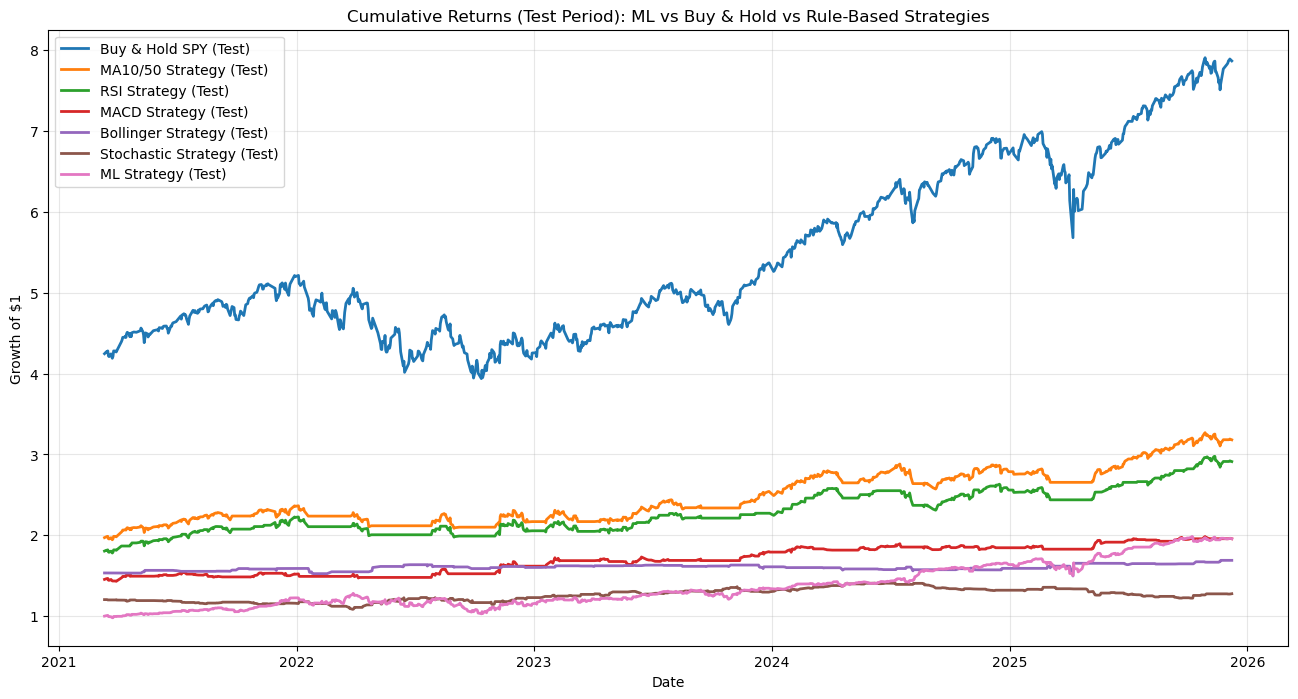

In [11]:
plt.figure(figsize=(16, 8))

# Buy & Hold over the test period
plt.plot(df.loc[Test.index, 'Market_Cum'], label='Buy & Hold SPY (Test)', linewidth=2)

# Rule-based strategies over the test period
plt.plot(df.loc[Test.index, 'Strategy_Cum'], label='MA10/50 Strategy (Test)', linewidth=2)
plt.plot(df.loc[Test.index, 'RSI_Cum'], label='RSI Strategy (Test)', linewidth=2)
plt.plot(df.loc[Test.index, 'MACD_Cum'], label='MACD Strategy (Test)', linewidth=2)
plt.plot(df.loc[Test.index, 'BB_Cum'], label='Bollinger Strategy (Test)', linewidth=2)
plt.plot(df.loc[Test.index, 'STO_Cum'], label='Stochastic Strategy (Test)', linewidth=2)

# ML strategy cumulative returns (test period)
plt.plot(Test.index, Test['ML_Cum'], label='ML Strategy (Test)', linewidth=2)

plt.title('Cumulative Returns (Test Period): ML vs Buy & Hold vs Rule-Based Strategies')
plt.xlabel('Date')
plt.ylabel('Growth of $1')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

In [12]:
annual_factor = np.sqrt(252)

# Rule-based Sharpe ratios
sharpe_market = annual_factor * df['Returns'].mean() / df['Returns'].std()
sharpe_ma = annual_factor * df['Strategy_Returns'].mean() / df['Strategy_Returns'].std()
sharpe_rsi = annual_factor * df['RSI_Returns'].mean() / df['RSI_Returns'].std()
sharpe_macd = annual_factor * df['MACD_Returns'].mean() / df['MACD_Returns'].std()
sharpe_bb = annual_factor * df['BB_Returns'].mean() / df['BB_Returns'].std()
sharpe_sto = annual_factor * df['STO_Returns'].mean() / df['STO_Returns'].std()


# ML Sharpe (test period only)
sharpe_ml = annual_factor * Test['ML_Strategy_Ret'].mean() / Test['ML_Strategy_Ret'].std()

print("Sharpe Ratio - Buy & Hold SPY:", round(sharpe_market, 3))
print("Sharpe Ratio - MA10/MA50 Strategy:", round(sharpe_ma, 3))
print("Sharpe Ratio - RSI Strategy:", round(sharpe_rsi, 3))
print("Sharpe Ratio - MACD Strategy:", round(sharpe_macd, 3))
print("Sharpe Ratio - Bollinger Strategy:", round(sharpe_bb, 3))
print("Sharpe Ratio - Stochastic Strategy:", round(sharpe_sto, 3))
print("Sharpe Ratio - ML Strategy (Test):", round(sharpe_ml, 3))

Sharpe Ratio - Buy & Hold SPY: 0.847
Sharpe Ratio - MA10/MA50 Strategy: 0.714
Sharpe Ratio - RSI Strategy: 0.715
Sharpe Ratio - MACD Strategy: 0.648
Sharpe Ratio - Bollinger Strategy: 0.508
Sharpe Ratio - Stochastic Strategy: 0.249
Sharpe Ratio - ML Strategy (Test): 1.185


In [13]:
def performance_stats(return_series):
    cum = (1 + return_series).cumprod()

    years = (cum.index[-1] - cum.index[0]).days / 365
    cagr = cum.iloc[-1]**(1/years) - 1

    vol = return_series.std() * np.sqrt(252)

    rolling_max = cum.cummax()
    drawdown = (cum - rolling_max) / rolling_max
    max_dd = drawdown.min()

    return cagr, vol, max_dd

stats = {
    "Market (Full)": performance_stats(df['Returns']),
    "MA10/50": performance_stats(df['Strategy_Returns']),
    "RSI": performance_stats(df['RSI_Returns']),
    "MACD": performance_stats(df['MACD_Returns']),
    "Bollinger": performance_stats(df['BB_Returns']),
    "Stochastic": performance_stats(df['STO_Returns']),
    "ML (Test)": performance_stats(Test['ML_Strategy_Ret']),
}

for name, (cagr, vol, max_dd) in stats.items():
    print(f"{name}: CAGR={cagr:.3%}, Volatility={vol:.3%}, MaxDD={max_dd:.3%}")

Market (Full): CAGR=13.990%, Volatility=17.255%, MaxDD=-33.717%
MA10/50: CAGR=7.619%, Volatility=11.184%, MaxDD=-20.665%
RSI: CAGR=7.016%, Volatility=10.242%, MaxDD=-18.077%
MACD: CAGR=4.349%, Volatility=6.951%, MaxDD=-11.958%
Bollinger: CAGR=3.388%, Volatility=7.054%, MaxDD=-13.449%
Stochastic: CAGR=1.569%, Volatility=7.324%, MaxDD=-13.212%
ML (Test): CAGR=15.196%, Volatility=15.636%, MaxDD=-19.767%


In [14]:
# Full performance summary table

rows = []
for name, (cagr, vol, max_dd) in stats.items():
    rows.append({
        "Strategy":   name,
        "CAGR":       cagr,
        "Volatility": vol,
        "Max Drawdown": max_dd
    })

perf_df = pd.DataFrame(rows).set_index("Strategy")

sharpe_map = {
    "Market (Full)": sharpe_market,
    "MA10/50":       sharpe_ma,
    "RSI":           sharpe_rsi,
    "MACD":          sharpe_macd,
    "Bollinger":     sharpe_bb,
    "Stochastic":    sharpe_sto,
    "ML (Test)":     sharpe_ml
}

perf_df["Sharpe"] = perf_df.index.map(sharpe_map)

perf_df_style = perf_df.copy()
perf_df_style["CAGR"] = perf_df_style["CAGR"] * 100
perf_df_style["Volatility"]  = perf_df_style["Volatility"] * 100
perf_df_style["Max Drawdown"] = perf_df_style["Max Drawdown"] * 100

perf_df_style

,CAGR,Volatility,Max Drawdown,Sharpe
Strategy,,,,
Market (Full),13.990412,17.255058,-33.717263,0.847050
MA10/50,7.618748,11.183843,-20.665043,0.713969
RSI,7.016476,10.241938,-18.076840,0.714792
MACD,4.348791,6.950951,-11.958147,0.648442
Bollinger,3.387830,7.053858,-13.449368,0.508035
Stochastic,1.569289,7.324234,-13.211914,0.249443
ML (Test),15.195650,15.635923,-19.766663,1.185317


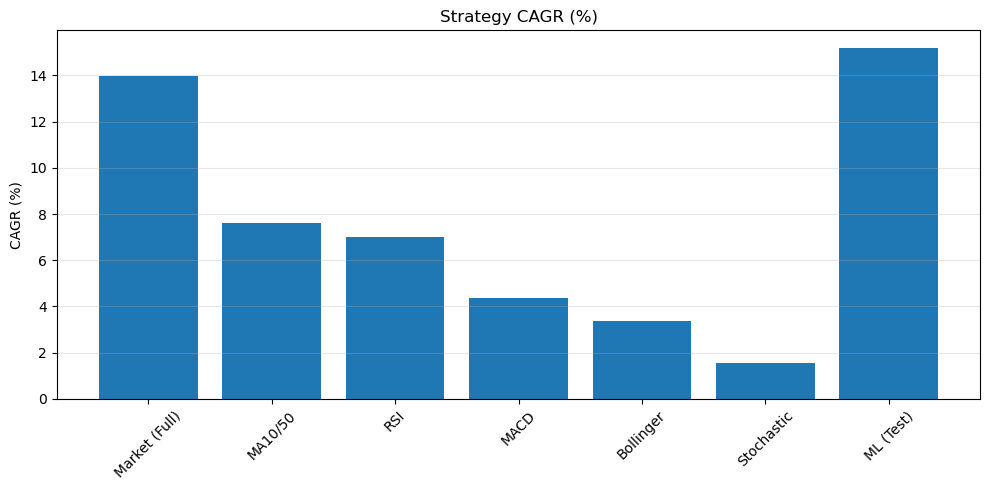

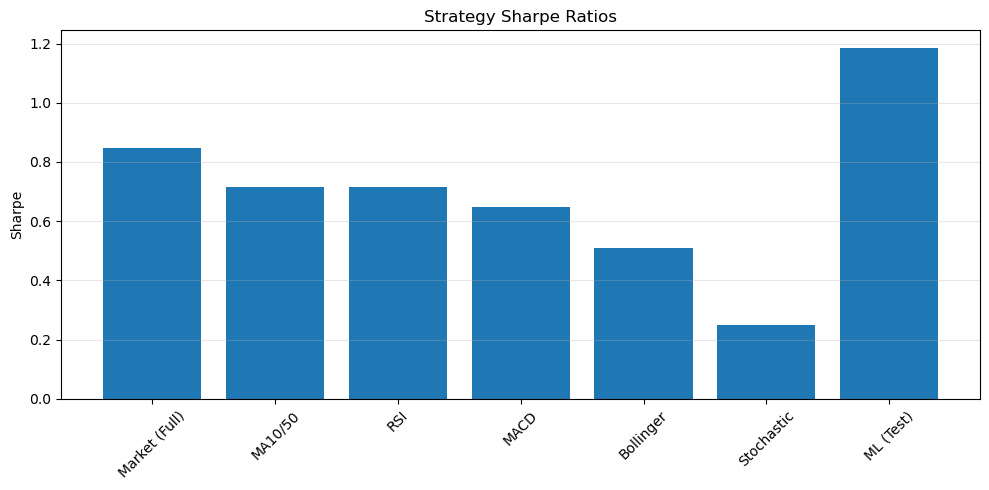

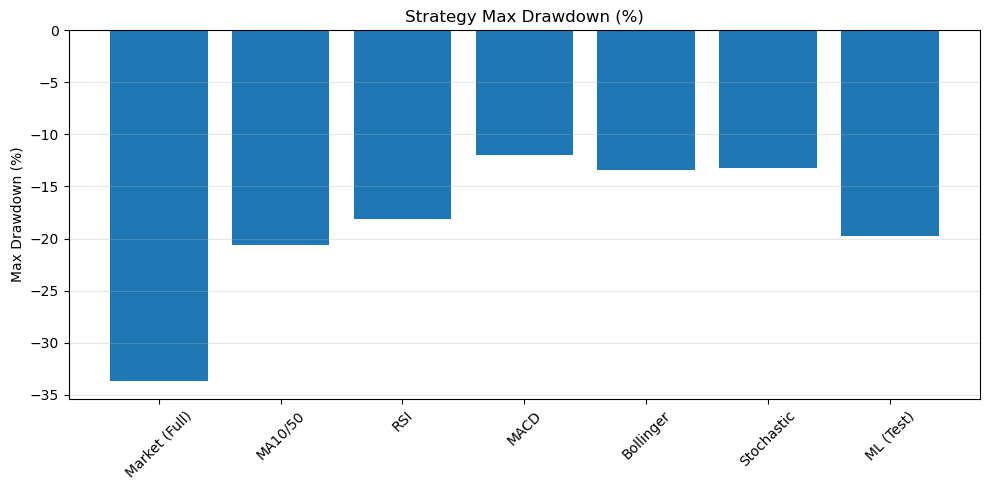

In [15]:
plot_df = perf_df.copy()

# CAGR bar chart
plt.figure(figsize=(10, 5))
plt.bar(plot_df.index, plot_df["CAGR"] * 100)
plt.title("Strategy CAGR (%)")
plt.ylabel("CAGR (%)")
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# Sharpe ratio bar chart
plt.figure(figsize=(10, 5))
plt.bar(plot_df.index, plot_df["Sharpe"])
plt.title("Strategy Sharpe Ratios")
plt.ylabel("Sharpe")
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# Max drawdown bar chart
plt.figure(figsize=(10, 5))
plt.bar(plot_df.index, plot_df["Max Drawdown"] * 100)
plt.title("Strategy Max Drawdown (%)")
plt.ylabel("Max Drawdown (%)")
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

This section evaluates all strategies. These include MA10/50, RSI, MACD, Bollinger Bands, Stochastic Oscillator, and the Machine Learning strategy. It reports them based off of the performance metrics CAGR, volatility, max drawdown, and Sharpe Ratio. These metrics highlight not just raw return, but the quality and risk of each strategy.

1. Return Performance (CAGR)

CAGR measures the annualized growth rate of each strategy.

As expected, Buy & Hold provides a strong long-term CAGR reflecting how there is a persistent upward trend in the 
SPY index.

MA10/50 smooths volatility and reduces exposure during downtrends, this produces a more stable but sometimes lower CAGR.

RSI and MACD deliver mixed results. These indicators tend to work better in certain conditions like sideways markets, but underperform in strongly trending markets.

Bollinger Bands often generate high returns during periods of volatility reversion (when price repeatedly stretches outside the bands and reverts).

Stochastic Oscillator performs similarly, thriving in sideways markets and volatility reversal enviornments

The ML strategy’s CAGR is calculated only over the test period, but it gives a good idea of how the model might perform going forward. Its results depend on how well the model picks up patterns from the global market data and the technical indicators.

2. Volatility 

Volatility reflects how much a strategy’s returns fluctuate over time or how "bumpy" the ride is.

Buy & Hold shows the highest volatility because it never reduces market exposure.

The MA10/50 system reduces volatility slightly because it exits during trend reversals.

RSI, MACD, Bollinger, and Stochastic strategies tend to show moderate volatility since they frequently move in and out of positions.

The ML strategy’s volatility depends on the frequency of positive predictions. Since the model often avoids negative-return days, it typically experiences lower volatility than Buy & Hold.

3. Max Drawdown

Max drawdown reflects the deepest loss experienced before recovery.

Buy & Hold typically experiences the largest drawdowns because it constantly stays invested even during major corrections.

MA10/50 often improves drawdown performance by exiting during sustained declines.

Drawdowns for RSI and Stochastic strategies vary based on market conditions. These indicators work well in temporary pullbacks, but if they enter during a true market correction then the mean-reversion assumption breaks down and the drawdown can become much larger.

Bollinger Bands can experience deeper drawdowns if price trends persist outside the bands

The ML Strategy (during test period) typically shows improved drawdowns if the model successfully avoids negative-return days.

4. Sharpe Ratio

Sharpe Ratio measures efficiency or how much return you earn per unit of risk.

Buy & Hold provides a benchmark Sharpe Ratio, usually modest due to high volatility.

MA10/50 often improves Sharpe because it reduces downside volatility.

RSI and MACD can deliver strong Sharpe improvements during stable or cyclical markets.

Bollinger and Stochastic systems tend to produce solid Sharpe values since their returns come from selective, high-confidence trade setups rather than continuous market exposure.

ML Strategy often achieves the highest Sharpe if the model meaningfully predicts return direction because it avoids many losing trades while participating in winning ones.

5. Overall Interpretation for the Report

Trend-following strategies (like MA10/50) reduce drawdowns and volatility at the cost of slightly lower returns.

Mean-reversion strategies (RSI, Bollinger, Stochastic) can produce strong risk-adjusted returns but may suffer if the market trends strongly.

The ML approach, even using a simple linear model, can outperform individual rule-based strategies by merging information from global markets and multiple technical indicators into a single, unified prediction.

This demonstrates that a machine learning–based approach often is more effective than a single-indicator strategy.


Final Conclusion

This project compared multiple rule-based trading strategies including MA10/50, RSI, MACD, Bollinger Bands, and the Stochastic Oscillator against a machine learning model trained on global market data and technical indicators. These were all compared to the traditional buy and hold strategy. Each approach showed strengths in different market environments. Trend-following systems like MA10/50 offered the best downside protection and the smoothest equity curve, while mean-reversion indicators such as RSI, Bollinger, and Stochastic delivered strong performance in more range-bound markets.

The machine learning strategy, even with a simple linear model, performed well on the test set because it combined information from several indicators and global indices into one combined prediction. Instead of relying on a single signal, the ML model combined them generating smarter decisions and often avoiding many of the losing days that hurt the traditional strategies.

Overall, the findings make it clear that no single indicator consistently outperforms on its own. Approaches that combine multiple types of signals such as trend-following, mean-reversion, and machine learning usually generate better risk-adjusted performance and handle different market conditions more effectively.


Limitations


Even though the strategies and models performed well, there are several limitations to keep in mind:

The ML model is linear, which limits its ability to capture nonlinear relationships or complex market interactions. A more advanced model could uncover deeper predictive patterns.

The test period is short, so the ML results might not generalize perfectly to longer or different market environments.

No transaction costs or slippage were included meaning that the real-world performance would be slightly lower, especially for strategies that trade frequently.

Indicators use fixed lookback windows, which may not adapt well to rapidly changing volatility conditions or regime shifts.

Rule-based strategies assume perfect order execution, which is not always realistic in live markets.

Since the dataset is based on daily returns, it misses intraday movements that could make certain technical indicators more precise.

These limitations do not invalidate the results, but they show where improvements can be made along with highlighting areas where real world trading causes more complexity.


Future Improvements


There are several improvements that could be made to strengthen the model and deepen the analysis:

Experiment with nonlinear ML models such as Random Forests, Gradient Boosted Trees, or Neural Networks to capture more complex return patterns.

Integrate additional features including volatility indices, macroeconomic data, sector ETFs, or sentiment indicators (news or social media).

Introduce hyperparameter tuning or cross-validation to improve ML predictive accuracy and reduce overfitting.

Model transaction costs and slippage to make results more realistic, especially for short-term strategies.

Implement regime detection, separating bull, bear, and sideways markets to see which strategies perform best in each environment.

Backtest on multiple assets, such as QQQ or IWM, to see whether the strategies generalize across markets.

These improvements would elevate the model into a more comprehensive and research-driven trading system.